In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def rotate_image(x):
    return x.rotate(90)

In [ ]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f7ec27bd5b9aba96eb879b0b6207359b54ecc2d5d64b82f7a2ee5b6f6ced4185
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.1 MB/s eta 0:00:00


In [ ]:
import time
import datetime
import os
import copy
import cv2
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import InterpolationMode
import timm

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=4)
image_size = EfficientNet.get_image_size('efficientnet-b3')
print(image_size)

NameError: name 'EfficientNet' is not defined

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
#배치 사이즈 조절
hyper_param_batch = 32
#랜덤성을 한가지로 맞추기 위해 시드 입력
random_seed = 100
random.seed(random_seed)
torch.manual_seed(random_seed)

num_classes = 4 # 분류할 클래스가 4개라는 뜻.
model_name = 'efficientnet-b3' # 모델명
# 폴더 경로 정하기
train_name = 'model1'

PATH = '/content/scalp_weights/'

data_train_path = '/content/gdrive/MyDrive/딥러닝/두피/미세각질 img/'
data_validation_path = '/content/gdrive/MyDrive/딥러닝/두피/미세각질 vail img/'

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
# 모델 이름은 Efficientnet-b3 , 클래스는 4개로 분류하는 모델 생성
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
model = model.to(device) # 모델을 GPU(없으면 cpu)에 적용
# 데이터의 증강 등 정제하는 과정
#interpolation :
# NEAREST(0)(얘가 제일 빠름) : 가장 가까운 이웃 픽셀의 값을 그대로 사용
# BOX(4) : 주변 픽셀의 가중평균을 사용
# BILINEAR(2) : 가까운 4개의 픽셀을 사용하여 선형 보간을 수행 , NEAREST보다 부드러움
# LANCZOS(1)(얘가 제일 느림) , BICUBIC(3)은 각각 BILINEAR의 기반이지만 , 더 정교하게 보간 , BILINEAR -> BICUBIC -> LANCZOS 순으로 느림
# HAMMING(5) : BOX와 유사하지만 , 얘가 더 정교하고 느림
# 가중 평균 : 주변 픽셀에 가중치를 곱해서 각각 더하고 , 줬던 가중치의 총합으로 나눠서 나오는 값이 가중평균
# 선형 보간 : 선으로 잇고 , 그 영역 안에서의 보간을 수행하는 것 ( 직선이면 직선상에서 )
transforms_train = transforms.Compose([
                                        transforms.Resize([int(image_size), int(image_size)], interpolation = InterpolationMode.BILINEAR),#크기 조절 , interpolation은 어떤 형식으로 보간할건지 정하는 것.
                                        transforms.RandomHorizontalFlip(p=0.5), # 수평뒤집기
                                        transforms.RandomVerticalFlip(p=0.5), # 수직뒤집기
                                        transforms.Lambda(lambda x: x.rotate(90)), # 90도 돌리기
                                        transforms.RandomRotation(10), # 0 ~~ 10까지 랜덤으로 회전
                                        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # 10도만큼 비틀고 , 80% ~~ 120%로 늘리거나 줄임
                                        transforms.ToTensor(), # tensor로 바꾸기
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 정규화 , 수치는 ImageNet에서 널리 사용되는 수치
                                      ])

transforms_val = transforms.Compose([
                                        transforms.Resize([int(image_size), int(image_size)], interpolation = InterpolationMode.BILINEAR),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])


train_data_set = datasets.ImageFolder(data_train_path, transform=transforms_train) # data_train_path라는 폴더에서 이미지들을 가져와 위의 증강 과정을 거침
val_data_set = datasets.ImageFolder(data_validation_path, transform=transforms_val)
# dict 지정
dataloaders, batch_num = {}, {}

dataloaders['train'] = DataLoader(train_data_set,
                                    batch_size=hyper_param_batch, # 몇개씩 배치할 것인지
                                    shuffle=True, # epoch마다 섞을 것인지

                                    num_workers=4) # 크면 클수록 데이터를 빠르게 로드할 수 있지만 , 메모리 낭비가 심함
dataloaders['val'] = DataLoader(val_data_set,
                                    batch_size=hyper_param_batch,
                                    shuffle=False,
                                    num_workers=4)

batch_num['train'], batch_num['val'] = len(train_data_set), len(val_data_set) # 학습할 데이터셋들의 크기 확인

print('batch_size : %d,  train/val : %d / %d' % (hyper_param_batch, batch_num['train'], batch_num['val'])) # 최종적으로 학습할 데이터 규모 확인

class_names = train_data_set.classes
print(class_names) # 사용될 4개의 클래스 확인

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    start_time = time.time()

    since = time.time()
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_loss, train_acc, val_loss, val_acc = [], [], [], []

    consecutive_epochs_without_improvement = 0  # 연속 에포크 동안 개선이 없는 횟수를 세는 카운터

    for epoch in range(num_epochs):
        print('에포크 {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_start = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_cnt = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)

            if phase == 'train':
                scheduler.step()

            epoch_loss = float(running_loss / num_cnt)
            epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                consecutive_epochs_without_improvement = 0
                print('==> 최고 성능 모델 저장 - %d / %.1f'%(best_idx, best_acc))
            elif phase == 'val':
                consecutive_epochs_without_improvement += 1

        epoch_end = time.time() - epoch_start
        print('에포크 {} 소요 시간 {:.0f}m {:.0f}s'.format(epoch, epoch_end // 60, epoch_end % 60))
        print()

        if consecutive_epochs_without_improvement >= patience:
            print('조기 종료: 연속된 {}번의 에포크 동안 성능 개선 없음'.format(patience))
            break

    time_elapsed = time.time() - since
    print('학습 완료 소요 시간 {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('최고 성능 Acc: %d - %.1f' %(best_idx, best_acc))

    model.load_state_dict(best_model_wts)

    torch.save(model, PATH + 'aram_'+train_name+'.pt')
    torch.save(model.state_dict(), PATH + 'president_aram_'+train_name+'.pt')
    print('모델 저장 완료')

    end_sec = time.time() - start_time
    end_times = str(datetime.timedelta(seconds=end_sec)).split('.')
    end_time = end_times[0]
    print("종료 시간 :", end_time)

    return model, best_idx, best_acc, train_loss, train_acc, val_loss, val_acc


criterion = nn.CrossEntropyLoss() # 손실함수

optimizer_ft = optim.Adam(model.parameters(),lr = 1e-4) # 모델 활성화함수를 Adam , 학습률은 1e - 4로 설정
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) # step_size만큼의 에포크마다 학습률에 gamma를 곱해서 갱신, 0.001

num_epochs = 100
train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

cuda:0
300
Loaded pretrained weights for efficientnet-b3
batch_size : 32,  train/val : 12739 / 3639
['[원천]미세각질_0.양호', '[원천]미세각질_1.경증', '[원천]미세각질_2.중등도', '[원천]미세각질_3.중증']
에포크 0/99
----------
train Loss: 0.8767 Acc: 60.5856
val Loss: 0.8356 Acc: 62.3248
==> 최고 성능 모델 저장 - 0 / 62.3
에포크 0 소요 시간 2m 3s

에포크 1/99
----------
train Loss: 0.7448 Acc: 66.7321
val Loss: 0.8632 Acc: 60.1264
에포크 1 소요 시간 2m 3s

에포크 2/99
----------
train Loss: 0.7095 Acc: 68.1765
val Loss: 0.8803 Acc: 60.7035
에포크 2 소요 시간 2m 3s

에포크 3/99
----------
train Loss: 0.6846 Acc: 69.5345
val Loss: 0.8701 Acc: 62.7095
==> 최고 성능 모델 저장 - 3 / 62.7
에포크 3 소요 시간 2m 2s

에포크 4/99
----------
train Loss: 0.6544 Acc: 70.9789
val Loss: 0.8636 Acc: 61.3630
에포크 4 소요 시간 2m 2s

에포크 5/99
----------
train Loss: 0.6154 Acc: 72.8001
val Loss: 0.8985 Acc: 62.4897
에포크 5 소요 시간 2m 2s

에포크 6/99
----------
train Loss: 0.5778 Acc: 74.8332
val Loss: 0.9517 Acc: 61.0882
에포크 6 소요 시간 2m 2s

에포크 7/99
----

(EfficientNet(
   (_conv_stem): Conv2dStaticSamePadding(
     3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
     (static_padding): ZeroPad2d((0, 1, 0, 1))
   )
   (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
   (_blocks): ModuleList(
     (0): MBConvBlock(
       (_depthwise_conv): Conv2dStaticSamePadding(
         40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
         (static_padding): ZeroPad2d((1, 1, 1, 1))
       )
       (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
       (_se_reduce): Conv2dStaticSamePadding(
         40, 10, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_se_expand): Conv2dStaticSamePadding(
         10, 40, kernel_size=(1, 1), stride=(1, 1)
         (static_padding): Identity()
       )
       (_project_conv): Conv2dStaticSamePadding(
         40, 24, kernel_size=(1, 1), strid

In [ ]:
from google.colab import files

# 저장된 모델 파일 다운로드
files.download('/content/scalp_weights/aram_model1.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_loss = [0.8767 , 0.7448 , 0.7095 , 0.6846 , 0.6544 , 0.6154 , 0.5778 , 0.5056 , 0.4771]
var_loss = [0.8356 , 0.8632 , 0.8803 , 0.8701 , 0.8636 , 0.8985 , 0.9517 , 0.9255 , 0.9439]

train_acc = [60.5856 , 66.7321 , 68.1765 , 69.5345 , 70.9789 , 72.8001 , 74.8332 , 78.4991 , 80.1868]
var_acc = [62.3248 , 60.1264 , 60.7035 , 62.7095 , 61.3630 , 62.4897 , 61.0882 , 62.6821 , 62.2973]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

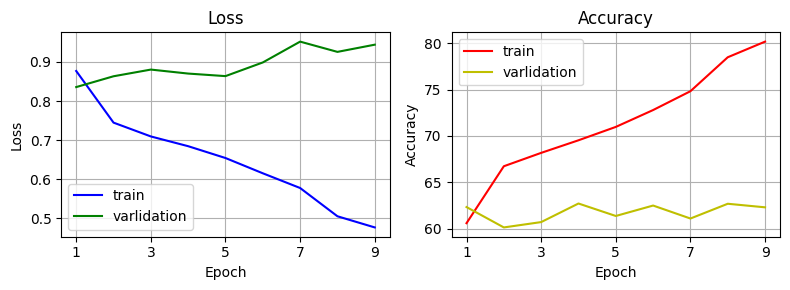

In [ ]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
plt.plot(train_loss , label = 'train' , color = 'b')
plt.plot(var_loss , label = 'varlidation' , color = 'g')
plt.legend()
plt.title('Loss')
plt.xticks(np.arange(len(train_loss)) , np.arange(1, len(train_loss) + 1))
plt.xticks(range(0, len(train_loss) + 1, 2))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

plt.subplot(1,2,2)
plt.plot(train_acc , label = 'train' , color = 'r')
plt.plot(var_acc , label = 'varlidation' , color = 'y')
plt.legend()
plt.title('Accuracy')
plt.xticks(np.arange(len(train_loss)) , np.arange(1, len(train_loss) + 1))
plt.xticks(range(0, len(train_loss) + 1, 2))

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.tight_layout()
plt.show()


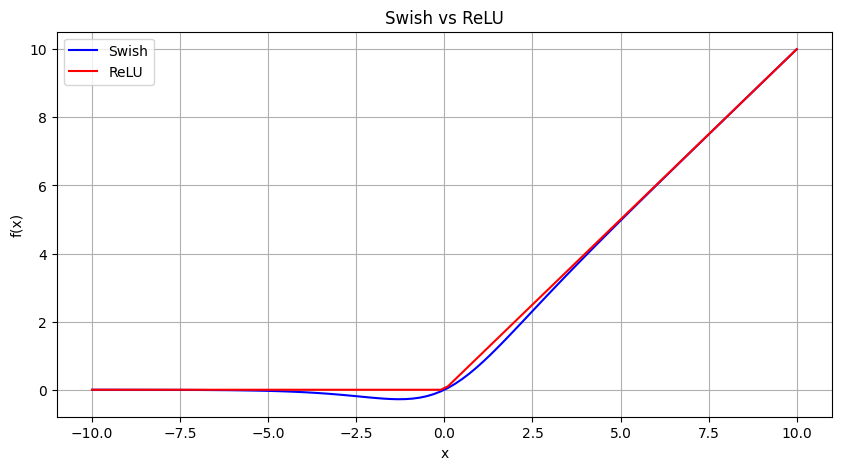

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def swish(x, beta=1):
    return x * (1 / (1 + np.exp(-beta * x)))

def relu(x):
    return np.maximum(0, x)

# 값 범위 설정
x = np.linspace(-10, 10, 100)

# 함수 계산
y_swish = swish(x)
y_relu = relu(x)

# 그래프 그리기
plt.figure(figsize=(10, 5))

plt.plot(x, y_swish, label='Swish', color='blue')
plt.plot(x, y_relu, label='ReLU', color='red')

plt.title('Swish vs ReLU')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)

# tanh 함수 계산
# y = np.tanh(x)

# # 그래프 생성
# plt.plot(x, y , label = 'tanh' , color = 'purple')

# plt.xlabel("x")
# plt.ylabel("tanh(x)")
plt.legend()
# plt.grid(True)
plt.show()